.. _nb_mixed_variable:

## Mixed Variable Problem

In some cases, variables might have different types; some might be real, discrete (choice), binary, or integer-valued. For those cases, different evolutionary operators must be applied to different types of variables. In **pymoo** this is supported by defining a `MixedVariableProblem` where the `vars` values are set. For example, let us consider the following optimization problem:

In [1]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Real, Integer, Choice, Binary


class MixedVariableProblem(ElementwiseProblem):

    def __init__(self, **kwargs):
        vars = {
            "b": Binary(),
            "x": Choice(options=["nothing", "multiply"]),
            "y": Integer(bounds=(-2, 2)),
            "z": Real(bounds=(-5, 5)),
        }
        super().__init__(vars=vars, n_obj=1, n_ieq_constr=1, **kwargs)

    def _evaluate(self, X, out, *args, **kwargs):
        b, x, z, y = X["b"], X["x"], X["z"], X["y"]

        f = z + y
        if b:
            f = 100 * f

        if x == "multiply":
            f = 10 * f

        out["F"] = f
        out["G"] = 3 - z - y


In order to solve such a problem, pymoo offers `MixedVariableGA`, which defines different operators for each variable type. For more details, please look at the implementation itself.

In [2]:
from pymoo.core.mixed import MixedVariableGA
from pymoo.core.variable import Real, Integer
from pymoo.optimize import minimize

problem = MixedVariableProblem()

algorithm = MixedVariableGA(pop=10)

res = minimize(problem,
               algorithm,
               termination=('n_evals', 300),
               seed=1,
               verbose=False)

print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))

Best solution found: 
X = {'b': False, 'x': 'nothing', 'y': -1, 'z': 4.137460357226896}
F = [3.13746036]


Moreover, for single-objective optimization, the well-known Hyperparameter optimization framework [Optuna](https://optuna.org) can be used (pymoo only wraps to their interface here. Congrats on their excellent work!).

In [3]:
from pymoo.algorithms.soo.nonconvex.optuna import Optuna
from pymoo.core.variable import Real, Integer
from pymoo.optimize import minimize

problem = MixedVariableProblem()

algorithm = Optuna()

res = minimize(problem,
               algorithm,
               termination=('n_evals', 500),
               seed=1,
               verbose=False)

print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))

Best solution found: 
X = {'b': True, 'x': 'multiply', 'y': 2, 'z': 2.481656543798394}
F = [4481.6565438]


Moreover, if you intend to solve a multi-objective optimization problem, you can either instantiate existing algorithms with `MixedVariableMating` or add a multi-objective survival to `MixedVariableGA`. The latter can be realized, for instance by:

In [4]:
class MultiObjectiveMixedVariableProblem(ElementwiseProblem):

    def __init__(self, **kwargs):
        vars = {
            "b": Binary(),
            "x": Choice(options=["nothing", "multiply"]),
            "y": Integer(bounds=(-2, 2)),
            "z": Real(bounds=(-5, 5)),
        }
        super().__init__(vars=vars, n_obj=2, n_ieq_constr=0, **kwargs)

    def _evaluate(self, X, out, *args, **kwargs):
        b, x, z, y = X["b"], X["x"], X["z"], X["y"]

        f1 = z ** 2 + y ** 2
        f2 = (z+2) ** 2 + (y-1) ** 2

        if b:
            f2 = 100 * f2

        if x == "multiply":
            f2 = 10 * f2

        out["F"] = [f1, f2]


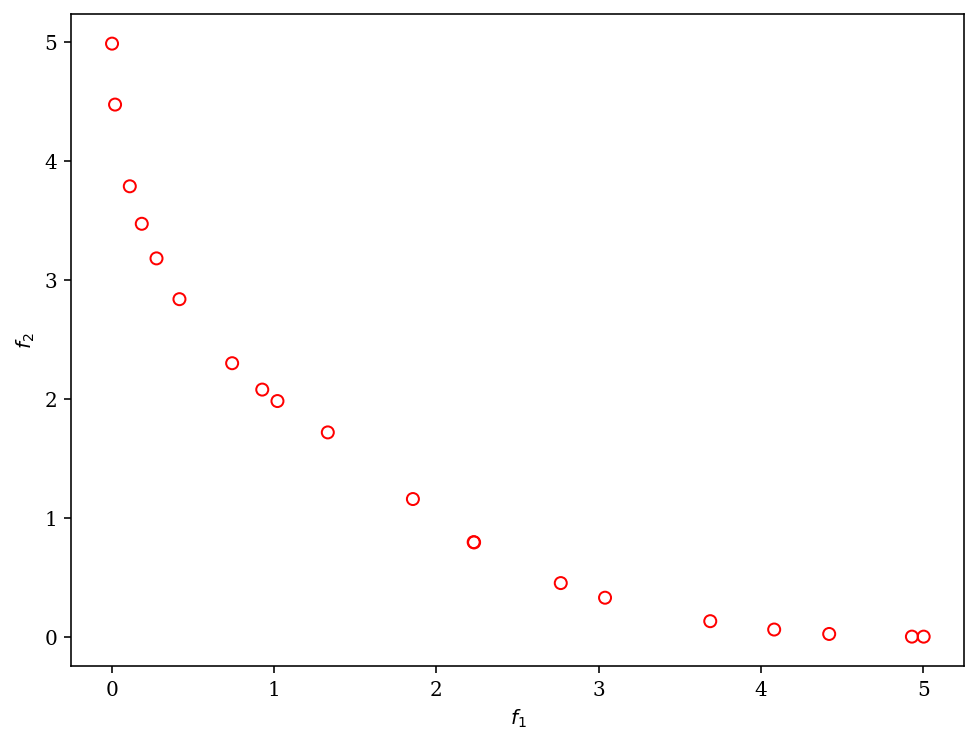

In [5]:
from pymoo.visualization.scatter import Scatter
from pymoo.algorithms.moo.nsga2 import RankAndCrowdingSurvival
from pymoo.core.mixed import MixedVariableGA
from pymoo.optimize import minimize

problem = MultiObjectiveMixedVariableProblem()

algorithm = MixedVariableGA(pop_size=20, survival=RankAndCrowdingSurvival())

res = minimize(problem,
               algorithm,
               ('n_gen', 50),
               seed=1,
               verbose=False)

plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()